In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-20 20:37:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-03-20 20:37:47 (123 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



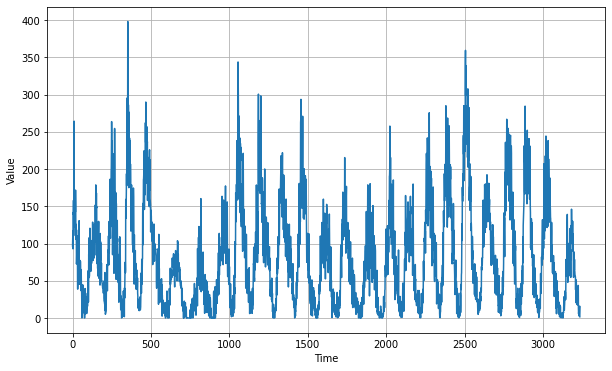

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

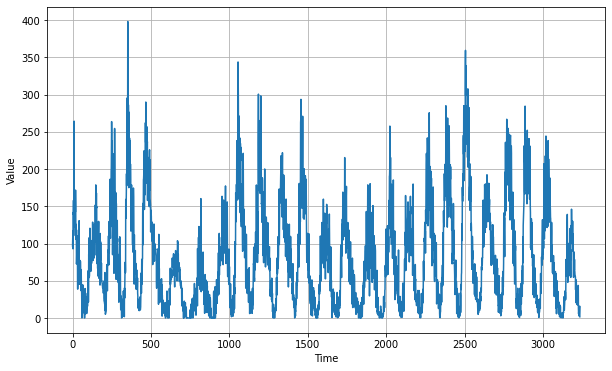

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 34s 30ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 29ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 62.9767 - mae: 63.4739
Epoch 7/100
12/12 [==============================] - 0s 30ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 0s 30ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

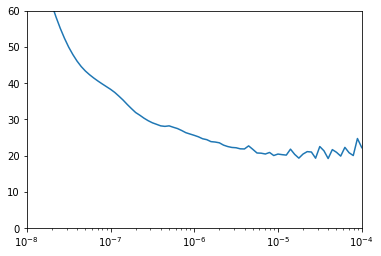

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 31ms/step - loss: 47.7147 - mae: 48.2118
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 26.8789 - mae: 27.3738
Epoch 3/500
30/30 [==============================] - 1s 15ms/step - loss: 22.9712 - mae: 23.4658
Epoch 4/500
30/30 [==============================] - 1s 16ms/step - loss: 20.2667 - mae: 20.7600
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 19.3666 - mae: 19.8590
Epoch 6/500
30/30 [==============================] - 1s 16ms/step - loss: 19.5618 - mae: 20.0541
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 18.6002 - mae: 19.0921
Epoch 8/500
30/30 [==============================] - 1s 16ms/step - loss: 17.9214 - mae: 18.4126
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 17.9485 - mae: 18.4396
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 19.8616 - mae: 20.3535
Epoch 11/500
30/30 [=========

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

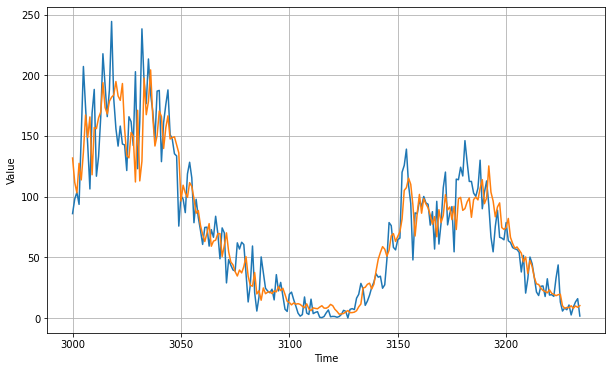

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.039624

<Figure size 432x288 with 0 Axes>

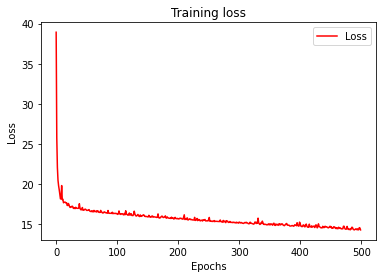

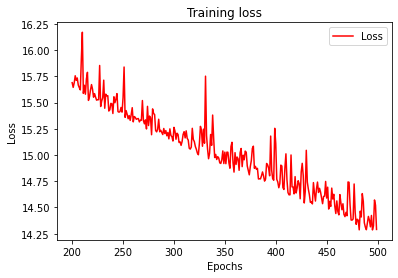

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[131.78305   111.674774  103.09062   127.39207   113.73164   136.6089
 167.22481   148.70453   165.6483    117.98276   156.97853   155.96938
 164.88075   169.75604   193.88658   173.45512   168.09445   178.60176
 181.90039   183.7283    194.82428   182.94125   179.30228   193.16127
 155.7795    133.87564   131.92093   152.81494   149.75038   112.0543
 171.10461   112.93274   129.18465   197.63333   167.49303   178.48682
 204.36774   165.28595   141.68102   150.40761   170.47961   165.95775
 139.65244   156.52962   166.52849   147.43846   148.62581   149.25949
 142.53253   136.06303    96.31981   109.38699   103.07844    99.385056
 111.49515   108.33096    98.2851     86.30912    88.47117    76.33202
  68.78704    62.986576   69.893906   77.75278    59.107857   63.343845
  64.077614   69.42332    69.53947    50.657852   59.619938   70.13713
  54.55584    46.17106    43.771954   38.199444   34.58202    39.52068
  37.147846   42.357704   50.52342    34.349983   26.948818   26.175446
  37.